In [1]:
%%js
var cells = Jupyter.notebook.get_cells();
           for (var i = 0; i < cells.length; i++) {
               var cur_cell = cells[i];
               var tags = cur_cell._metadata.tags;
               console.log(i);
               console.log(tags == undefined);
               console.log(tags);
               if (tags != undefined) {
               for (var j = 0; j < tags.length; j++) {
                  if (tags[j]=="book_only" | tags[j]=="remove-cell") {cur_cell.element.hide();}}
               for (var j = 0; j < tags.length; j++) {
                   if (tags[j]=="presentation_only") {cur_cell.element.show();}}
            }}

<IPython.core.display.Javascript object>

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.signal as sig
from scipy.integrate import simpson
from IPython.display import SVG, display, IFrame, HTML
import seaborn as sns
import torch
from scipy import misc
%matplotlib notebook
book = False

C:\Users\meyjoh\repos\vlcompimg\compimg\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
%matplotlib inline
book = True

In [4]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [5]:
%%javascript

MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [6]:
def showFig(path,i,ending, width, height):
    filename = path+str(i)+ending
    return HTML("<img src=\"" + filename +  f"\" style=\"max-height:{height}vh\"/>")

In [7]:
def showFig2(path,i,ending, width, height):
    imgToShow = plt.imread(f"{path}{i}{ending}")
    plt.imshow(imgToShow)

In [8]:
def imshow(img, cmap=None):
    plt.close('all')
    plt.figure()
    plt.imshow(img, cmap=cmap)
    plt.show()

In [9]:
def imshow2(img, cmap=None):
    #plt.close('all')
    #plt.figure()
    plt.clf()
    plt.imshow(img, cmap=cmap)
    #plt.show()

$\begin{align}
  \newcommand{transp}{^\intercal}
  \newcommand{F}{\mathcal{F}}
  \newcommand{Fi}{\mathcal{F}^{-1}}
  \newcommand{inv}{^{-1}}
  \newcommand{stochvec}[1]{\mathbf{\tilde{#1}}}
  \newcommand{argmax}[1]{\underset{#1}{\mathrm{arg\, max}}}
  \newcommand{argmin}[1]{\underset{#1}{\mathrm{arg\, min}}}
\end{align}$

<font size="7"> Computational Imaging </font><br><br><br>

# Inverse Problems in Computational Imaging

##### Content
* Introduction into inverse problems
* Image denoising
* General linear inverse problems
* Image deconvolution
* Inverse filter for deconvolution 
* Wiener filter for deconvolution
* Richardson-Lucy deconvolution
* Half-quadratic splitting method
* Alternating direction method of multipliers
* Deep SNR-estimation for Wiener filtering
* Unrolled optimization

## Introduction into inverse problems

An *inverse problem* represents the task of finding the input values to some function or process that produced certain output values which have been observed. Such problems are called *inverse*, as they start with the output and have the goal of finding the corresponding input.

Unfortunately, inverse problems often represent so-called *ill-posed problems*. A problem is considered to be ill-posed if one of the following properties holds:
* There is no solution to the problem,
* there is no unique solution, i.e., there are multiple possible inputs that explain the observed data,
* the solution does not change continuously w.r.t. to changes of the output.

A common approach to mitigate the difficulties involved with ill-posed inverse problems is to employ so-called *regularization methods* which usually use prior knowledge about the sought solution to guide the reconstruction process into the right direction.

## Image denoising

The goal of image denoising it to recover an original image $s(\mathbf{x})$ after is has been affected by additive, signal-independent noise $n(\mathbf{x})$, which is a common general assumption for noise present in digitally acquired images:

$\begin{align} 
   g(\mathbf{x}) = s(\mathbf{x}) + n(\mathbf{x}) \,.
\end{align}$

Note: The dependence on a spatial variable (e.g., like $\mathbf{x}$ for $g(\mathbf{x})$) is omitted for this chapter for the sake of clarity.

```{note}
  The dependence on a spatial variable (e.g., like $\mathbf{x}$ for $g(\mathbf{x})$) is omitted for this chapter for the sake of clarity.
```

* The pixel-wise noise $n_i$ follows a zero-mean i.i.d. normal distribution, i.e., $n_i \sim \mathcal{N}(0, \sigma ^2)$ and 
* the pixel $s_i$ of the undistorted image follow an i.i.d. normal distribution with zero variance, i.e., $s_i \sim \mathcal{N}(s_i, 0)$.
* Hence, the pixel $g_i$ of the observed image can be modelled via the sum of the two normal distributions, i.e., $g_i \sim \mathcal{N}(s_i, \sigma^2)$.

The per-pixel distribution of $g$ is given by

$\begin{align} 
   p(g_i \vert s_i, \sigma ) = \frac{1}{\sqrt{2\pi\sigma^2}} \mathrm{e}^{-\frac{(g_i - s_i)^2}{2\sigma^2}} \,.
\end{align}$

Due to the pixel-wise independence of the involved probabilities, the joint probability of the whole image is given by the product of the individual probabilities:

$\begin{align} 
   p(\mathbf{g}\vert \mathbf{s}, \sigma) = \prod\limits_i p(g_i\vert s_i, \sigma) \propto \mathrm{e}^{-\frac{\left\| \mathbf{g} - \mathbf{s} \right\|^2_2 }{2\sigma^2}} \,.
\end{align}$

Bayes' rule yields the posterior distribution for the sought undistorted image $\mathbf{s}$:

$\begin{align} 
   p(\mathbf{s} \vert \mathbf{g}, \sigma) = \frac{p(\mathbf{g}\vert \mathbf{s}, \sigma) p(\mathbf{s})}{p(\mathbf{g})} \propto p(\mathbf{g}\vert \mathbf{s}, \sigma) p(\mathbf{s})\,,
\end{align}$

with the a priori probability $p(\mathbf{s})$ of the sought image $\mathbf{s}$.

### Maximum a-posteriori (MAP) solution

The maximum a-posteriori (MAP) estimate of $ \mathbf{s}$ can be obtained by maximizing (minimizing) the (negative) natural logarithm of the posterior distribution:

$\begin{align} 
   \hat{\mathbf{s}}_\mathrm{MAP} &= \argmin{\mathbf{s}}\, -\log \left( p(\mathbf{s} \vert \mathbf{g}, \sigma) \right) \\
   &= \argmin{\mathbf{s}}\, - \log p(\mathbf{g}\vert \mathbf{s}, \sigma) - \log p(\mathbf{s}) \\
   &= \argmin{\mathbf{s}}\, \frac{1}{2\sigma^2}\left\| \mathbf{g} - \mathbf{s} \right\|^2_2 - \log p(\mathbf{s}) \\
   &= \argmin{\mathbf{s}}\, \frac{1}{2\sigma^2}\left\| \mathbf{g} - \mathbf{s} \right\|^2_2 + \Gamma (\mathbf{s}) \,,
\end{align}$

with $\Gamma(\mathbf{s})$ denoting the negative natural logarithm of the prior on $\mathbf{s}$.

If no information about the prior $p(\mathbf{s})$ is exploited, every pixel value has to be considered equally likely, i.e., $p(s_i) = 1$, resulting in a trivial but useless solution for the estimate of $\mathbf{s}$:

$\begin{align} 
   \hat{\mathbf{s}}_\mathrm{flat\ prior} = \argmin{\mathbf{s}}\, \frac{1}{2\sigma^2}\left\| \mathbf{g} - \mathbf{s} \right\|^2_2 = \mathbf{g} \,.
\end{align}$

We will get to know several suitable priors later on in this chapter but we want to stress one important point here:

Any algorithm that successfully denoises an image from normally distributed noise can be interpreted (and used) as a solution to the problem just described, i.e.,

$\begin{align} 
  \argmin{\mathbf{s}}\, \frac{1}{2\sigma^2}\left\| \mathbf{g} - \mathbf{s} \right\|^2_2 + \Gamma (\mathbf{s}) \,.
\end{align}$

## General linear inverse problems

For the general linear inverse problem, the vectorized image formation process is given by:

$\begin{align} 
   \mathbf{b} = \mathbf{Ax} + \mathbf{n} \,,
\end{align}$

where $\mathbf{b} \in \mathbb{R} ^M$ denotes the $M$ observations or measurements which are the result of the matrix-vector multiplication of the sought latent image $\mathbf{x} \in \mathbb{R} ^N$ with the so-called *measurement matrix* $\mathbf{A} \in \mathbb{R} ^{M \times N}$ and the term $\mathbf{n} \in \mathbb{R} ^M$ represents additive, signal-independent noise.

### Bayesian perspective of inverse problems

Interpret as random vectors:<br>
$\stochvec{x}\sim \mathcal{N}(\mathbf{x},0)$,<br>
$\stochvec{n}\sim \mathcal{N}(0,\sigma^2)$,<br>
$ \stochvec{b}\sim \mathcal{N}((\mathbf{Ax}),\sigma^2)$

For probability of observation $ \mathbf{b}$ it holds:

$\begin{align}
    p( \mathbf{b}\vert \mathbf{x}, \sigma) \propto \exp \left( - \frac{\Vert \mathbf{b} - \mathbf{Ax} \Vert^2_2}{2\sigma^2} \right)
\end{align}
$

According to Bayes' rule:

$\begin{align}
    \underbrace{p(\mathbf{x}\vert \mathbf{b},\sigma)}_{\mathrm{posterior}} = \frac{p( \mathbf{b}\vert \mathbf{x}, \sigma)\cdot p( \mathbf{x})}{p( \mathbf{b})} \propto \underbrace{p( \mathbf{b} \vert \mathbf{x}, \sigma)}_{\mathrm{image\ formation\ model}} \cdot \underbrace{p( \mathbf{x})}_\mathrm{prior}\,.
\end{align}
$

Maximum-a-posteriori (MAP) solution:

$\begin{align}
  \hat{x}_\mathrm{MAP} &= \argmax{\mathbf{x}}\, p(\mathbf{x}\vert \mathbf{b},\sigma) \\
                         &= \argmax{\mathbf{x}}\, \log p(\mathbf{x}\vert \mathbf{b},\sigma) \\
                         &= \argmin{ \mathbf{x}}\, - \log p(\mathbf{x}\vert \mathbf{b},\sigma) \\
                         &= \argmin{ \mathbf{x}}\, - \log p( \mathbf{b} \vert \mathbf{x}, \sigma) - \log p( \mathbf{x}) \\
                         \label{eq:map_solution}&= \argmin{ \mathbf{x}}\, \underbrace{\frac{\Vert \mathbf{b} - \mathbf{Ax} \Vert^2_2}{2\sigma^2}}_{\mathrm{data\, fidelity\, term}} + \underbrace{\Psi(\mathbf{x})}_{ \mathrm{regularizer}}\,.                         
\end{align}
$

The choice of image priors / regularizers depends on the imaging task, i.e., the nature of the images that are to be recovered. Examples are:
* Blurry imges $\rightarrow$ promote smoothness $\Psi (\mathbf{x}) = \left\| \underbrace{\Delta}_{\text{Laplace operator}} \mathbf{x} \right\|_2 $
* Sparse images (e.g., stars) $\rightarrow$ promote sparsity $\Psi (\mathbf{x}) = \left\| \mathbf{x} \right\|_1$
* Natural images $\rightarrow$ promote sparse gradients $\mathrm{TV}(\mathbf{x})$

### Total Variation

The intuition behind total variation is that in natural images, regions of almost constant intensities are separated by sharp edges. Hence, the gradient of such images can be assumed to be sparse.

The gradient is calculated by means of convolutions with the finite difference operators in $x$- and $y$-direction:

* Finite difference in $x$-direction: $d_x * x = \begin{pmatrix} 0 & 0 & 0 \\ 0 & -1 & 1 \\ 0 & 0 & 0  \end{pmatrix} * x = \mathbf{D}_x \mathbf{x}$
* Finite difference in $y$-direction: $d_y * x = \begin{pmatrix} 0 & 0 & 0 \\ 0 & -1 & 0 \\ 0 & 1 & 0  \end{pmatrix} * x = \mathbf{D}_y \mathbf{x}$

* Anisotropic: 

$\begin{align} 
  \mathrm{TV}(\mathbf{x}) &= \left\| \mathbf{D}_x \mathbf{x} \right\|_1 + \left\| \mathbf{D}_y \mathbf{x} \right\|_1 \\ 
  &=  \sum\limits^N_{i=1}  \left| (\mathbf{D}_x \mathbf{x})_i \right| + \left| (\mathbf{D}_y \mathbf{x})_i \right| = \sum\limits^N_{i=1} \sqrt[]{(\mathbf{D}_x \mathbf{x})^2_i} + \sum\limits^N_{i=1} \sqrt[]{(\mathbf{D}_y \mathbf{x})^2_i} 
\end{align}$
  
* Isotropic:

$\begin{align} 
  \mathrm{TV}(\mathbf{x}) = \sum\limits^N_{i=1}\left\| \begin{bmatrix} (\mathbf{D}_x \mathbf{x})_i \\ (\mathbf{D}_y \mathbf{x})_i \end{bmatrix} \right\|_2 = \sum\limits^N_{i=1}  \sqrt[]{(\mathbf{D}_x \mathbf{x})^2_i + (\mathbf{D}_y \mathbf{x})^2_i}
\end{align}\,,$

with $\begin{bmatrix} \mathbf{a} \\ \mathbf{b} \end{bmatrix}$ denoting a concatenation of the vectors $\mathbf{a}$ and $\mathbf{b}$ and $(\mathbf{D_\mathrm{x} \mathbf{x}})_i$ denoting the $i$-th element of the vector resulting from $\mathbf{D}_\mathrm{x} \mathbf{x}$.

## Image deconvolution

Image deconvolution deals with the problem of reconstructing an original image $s$ after it has been affected by a linear shift-invariant image degradation and additive noise, which together forms the observed image $g$.

With the impulse response $h$ of the image degradation, the observation can be modeled as

$\begin{align} \label{eq:img_formation}
   g = s * h + n\,,
\end{align}$

with the additive noise $n$.

The goal is to define a reconstruction filter $v$ that, when applied to the observation $g$, yields a reconstruction $\hat{s}$ matching the latent input $s$ as closely as possible.

The following figure visualizes the signal model of image deconvolution:

<img src="figures/6/signalmodel_reconstruction.svg" style="max-height:40vh">

Methods and approaches dealing with deconvolution can be divided into two groups:
1. *Blind* deconvolution: The kernel $h$ is assumed to be unknown and also has to be recovered / estimated.
2. *Non-blind* deconvolution: The kernel $h$ is assumed to be known.

<br>Note that there is some research which focuses on estimating the kernel $h$ and then employs non-blind deconvolution methods to perform the deconvolution.

According to the convolution theorem of the Fourier transform, equation $\eqref{eq:img_formation}$ can be expressed as:
$\begin{align}\label{eq:img_formation_fourier}
    g = \mathcal{F}^{-1}\lbrace \mathcal{F} \lbrace h \rbrace \cdot \mathcal{F} \lbrace s \rbrace \rbrace + n
\end{align}$

**Important note:** Equations $\eqref{eq:img_formation}$ and $\eqref{eq:img_formation_fourier}$ only result in the same numbers, if the convolution is performed with ciruclar boundary conditions, i.e., when the convolution kernel wraps around the image borders.

##### Duality between signal processing perspective and algebraic perspective

Since the convolution is a linear operator, it can also be expressed in terms of a matrix vector multiplication:
$\begin{align}\label{eq:duality}
    g = h*s \Leftrightarrow \mathbf{g} = \mathbf{H}\mathbf{s}\,,
\end{align}$
with a square circulant Toeplitz matrix $\mathbf{H}\in \mathbb{R}^{N\times N}$ implementing the convolution and $\mathbf{g,s} \in \mathbb{R}^N$ representing the vectorized forms of the corresponding images $g$ and $s$.

## Inverse filter for deconvolution

The inverse filter represents the straightforward approach of solving equation $\eqref{eq:img_formation_fourier}$ for $s$ while neglecting the noise $n$:
$\begin{align}\label{eq:inv_filter}
        \hat{s}_{\mathrm{inv}}=\Fi\left\lbrace \frac{\F\lbrace g \rbrace}{\F\lbrace h \rbrace } \right\rbrace \,.
\end{align}$

Properties of the inverse filter:
* computationally efficient,
* problematic for small values of $\F \lbrace h \rbrace$, (amplifies noise).

Unfortunately, the second point is true for most practically relevant point spread functions.

##### Example inverse filter reconstruction results for increasing noise levels

In [10]:
interact(lambda i: showFig('figures/6/inv_filter_res_',i,'.svg',800,50), i=widgets.IntSlider(min=(min_i:=1),max=(max_i:=6), step=1, value=(max_i if book else min_i)))

interactive(children=(IntSlider(value=6, description='i', max=6, min=1), Output()), _dom_classes=('widget-inte…

<function __main__.<lambda>(i)>

## Wiener filter for deconvolution

The Wiener filter has been proposed by Norbert Wiener in 1949 and minimizes the mean squared error between the original image $s$ and the reconstruction $\hat{s}$.

The filter is obtained by assuming the involved images to be weakly stationary stochastic processes so that they can be described via their power spectral densities (not covered here).

In the Fourier-domain, the Wiener filter is given by

$\begin{align} 
   V(\mathbf{f}) = \frac{H(\mathbf{f})^*}{\left| H(\mathbf{f}) \right|^2 + \underbrace{\frac{S_{nn}(\mathbf{f})}{S_{ss}(\mathbf{f})}}_{=:SNR^{-1}(\mathbf{f})} } \,,
\end{align}$

with $H(\mathbf{f})^*$ denoting the complex conjugate of $H(\mathbf{f})$ and $S_{nn}(\mathbf{f}), S_{ss}(\mathbf{f})$ denoting the power spectral densities of the noise $n$ and the original image $s$. The quotient $\frac{S_{ss}(\mathbf{f})}{S_{nn}(\mathbf{f})}$ represents the signal-to-noise ration $SNR(\mathbf{f})$ between $s$ and $n$.

For frequencies with high signal-to-noise ratios, the Wiener filter resembles the inverse filter and for low signal-to-noise ratios, it pulls yields values close to zero in order not to amplify any noise.

One of the main practical problems of the Wiener filter is the dependence on the signal-to-noise ratio $SNR(\mathbf{f})$ which can not be determined exactly as it involves the power spectral density of the unknown, original image $s$.

A common heuristic for providing the signal-to-noise ratio is 

$\begin{align} 
   SNR_\mathrm{{heur}} (\mathbf{f}) = \frac{1}{\left\| \mathbf{f} \right\|_2 } \,,
\end{align}$

i.e., to steadily decrease the filtering for higher spatial frequencies as noise is typically dominated by high spatial frequencies.

Later we will see another method for estimating the signal-to-noise ratio that takes the actual processed image $g$ into account.

##### Example Wiener filter reconstruction results for increasing noise levels with SNR-heuristics

In [11]:
interact(lambda i: showFig('figures/6/wiener_filter_res_',i,'.svg',800,50), i=widgets.IntSlider(min=(min_i:=1),max=(max_i:=6), step=1, value=(max_i if book else min_i)))

interactive(children=(IntSlider(value=6, description='i', max=6, min=1), Output()), _dom_classes=('widget-inte…

<function __main__.<lambda>(i)>

## Richardson-Lucy deconvolution

The Richardson-Lucy deconvolution algorithm (RL-algorithm) has been simultaneously and independently proposed by William Richardson and Leon Lucy in the 1970s. 

It is based on the assumption that the noise affecting digitally acquired images is dominated by the so-called *shot noise* caused by the stochastic nature of the number of arriving photons.

We again consider the image formation process

$\begin{align} 
   g = s * h + n\,,
\end{align}$

with the observed image $g$, the sought original image $s$, the convolution kernel $h$ and the additive noise $n$.

The probability $p(g)$ that a single pixel collects $g$ photons during one exposure period can be modelled by means of a Poisson distribution:

$\begin{align} 
   p(g) = \mathrm{e}^{-\lambda} \cdot \frac{\lambda^g}{g!} \,,
\end{align}$

with $\lambda$ denoting the expected number of photons collected during one exposure.

In order to obtain a noise-free image, one would need to obtain $\lambda$ by means of the measured $g$ photons (precisely, photoelectrons).

Since the joint probability of two independent events is the product of their individual probabilities, the joint probability of recording the intensities $g$ of a whole image can expressed via:

$\begin{align} 
   P(g) = \prod_{(x,y)\in \Omega_g} \mathrm{e}^{-\Lambda_{x,y}} \cdot \frac{\Lambda_{x,y}^{b_{x,y}}}{g_{x,y}!} \,,
\end{align}$

with $\Omega_g$ denoting the spatial support of the image $g$, $\Lambda_{x,y}$ denoting the value of the sought noise-free image $\Lambda$ at position $(x,y)$ and $g_{x,y}$ denoting the pixel value of the image $g$ at position $(x,y)$. All operations are considered element-wise. 

To improve readability, we will omit the pixel index $(x,y)$ from now on.

To obtain the noise-free image, we have to guess the hidden expected values $\hat{\Lambda}$ that match the observed image $g$ as closely as possible.

We can achieve this by finding a $\hat{\Lambda}$ that maximizes $P(g)$, or, equivalently, that maximizes $\log P(g)$:

$\begin{align} 
   \log P(g) &= \log \left( \prod \mathrm{e}^{-\Lambda} \cdot \frac{\Lambda^g}{g!} \right) \\
  &= \sum \log \left(  \mathrm{e}^{-\Lambda} \cdot \frac{\Lambda^g}{g!} \right) \\
  &= \sum \left( \log e^{-\Lambda} + g\log \Lambda - \log g! \right) \\
  &= -\sum \left( \Lambda-g\log \Lambda + \log g!  \right) \,,
\end{align}$

with $\log$ denoting the natural logarithm. 

The last term in the summation, i.e., $\log g!$, can be ignored since it does not depend on $\Lambda$.

The noise-free image $\Lambda$ is the result of

$\begin{align} 
   \Lambda = s * h \,,
\end{align}$

i.e., the convolution of the noise-free, original image $s$ with the convolution kernel $h$.

And the observed image $g$ is the result Of

$\begin{align} 
   g = s * h + n \,,
\end{align}$

i.e., $\Lambda$ with additive noise $n$.

These two expressions can be inserted into the equation of $\log P(g)$ in order to get to our optimization goal of finding an $\hat{s}$ that maximizes $\log P(g)$, i.e., minimizes $-\log P(g)$:

$\begin{align} 
  \hat{s} = \argmin{s}\, \underbrace{ \sum \left( s * h-g\log (s * h)  \right)}_{=:J(s)} \,,
\end{align}$

with the optimization functional $J(s)$.

To perform the optimization, we can employ gradient descent on $J(s)$. The gradient $\nabla J=\frac{\partial J(s)}{\partial s}$ of $J(s)$ w.r.t. $s$ is given by:

$\begin{align} 
  \nabla J(s) = \left( 1 - \frac{g}{s*h} \right) * h\transp \,,
\end{align}$

with element-wise multiplication and division.

For an initial guess of $\hat{s}_0 := g$, the gradient descent iteration for the Richardson-Lucy algorithm is

$\begin{align} 
  \hat{s}_{i+1} = \hat{s}_i - \eta \nabla J(s_i) = \hat{s}_i - \eta \left( 1 - \frac{g}{s_i*h} \right) * h\transp \,.
\end{align}$

### Multiplicative version of the Richardson-Lucy algorithm

The most implemented version of the RL-algorithm is the so-called *multiplicative RL-algorithm*. 

It relies on the convolution kernel $h$ being normalized, i.e., $\sum_{(i,j)} h_{i,j} = 1$.

This also implies that $1*h\transp=1$.

The multiplicative RL-algorithm is derived by equating $J(s)$ to zero. This results in:

$\begin{align} 
   1 = \frac{g}{s*h}*h\transp \,.
\end{align}$

Since $J(s)$ is a convex function, it decreases with every step of gradient descent until it does not change anymore, i.e., until it holds

$\begin{align} 
   \frac{\hat{s}_{i+1}}{\hat{s}_i} = 1 \,.
\end{align}$

We use this expression to substitute $1$ in the equation before and arrive at the sought multiplicative formulation of the RL-algorithm:

$\begin{align} 
  \frac{\hat{s}_{i+1}}{\hat{s}_i} &= \frac{g}{s*h}*h\transp \quad \Leftrightarrow \\
  \hat{s}_{i+1} &= \hat{s}_i \frac{g}{\hat{s}_i*h}*h\transp \,.
\end{align}$

##### Comments on the Richardson-Lucy algorithm

The RL-algorithm is implemented in many open source or commercial image processing libraries. 

The main problem of the RL-algorithm is that it starts to amplify noise after its (usually quick) convergence. Hence, the intermediate results have to be continuously inspected or some sort of regularization has to be incorporated into the optimization functional $J$.

## Half-quadratic splitting (HQS) method

This section introduces a flexible, powerful and intuitive iterative approach, the half-quadratic splitting (HQS) method, for solving regularized inverse problems formulated like \eqref{eq:map_solution}. 

We start with some general considerations and then apply HQS to the inverse problem of deconvolution.

We assume the following image formation model:

$\begin{align} 
  \mathbf{b} = \mathbf{Ax} + \mathbf{\eta},
\end{align}$

with $\mathbf{x}\in \mathbb{R}^{N}$ denoting the unknown vector, $\mathbf{b}\in \mathbb{R}^{M}$ representing the observations, the additive noise $\mathbf{\eta}\in \mathbb{R}^{M}$ and the matrix $\mathbf{A}\in \mathbb{R}^{M\times N}$ encoding the linear image formation model.

Equation \eqref{eq:map_solution} leads us to the general formulation of regularized inverse problems in the field of computational imaging:

$
\begin{align}\label{eq:general_inverse_problem} 
  \hat{\mathbf{x}} = \argmin{\mathbf{x}} \, \underbrace{\frac{1}{2} \left\| \mathbf{Ax-b} \right\|^2_2}_{\text{data fidelity term}} + \underbrace{\lambda \Psi (\mathbf{x}) }_{\text{regularizer}}\,.
\end{align}
$

 The data fidelity term ensures that the sought solution $\mathbf{\hat{x}}$ matches the observed data $\mathbf{b}$ when fed through the image formation process (modelled by $\mathbf{A}$). The regularization operator $\Psi : \mathbb{R}^{N} \rightarrow \mathbb{R}^M$ models prior knowledge about the unknown original data $\mathbf{x}$. The scalar parameter $\lambda $ balances between the data fidelity term and the regularization term and hence $\lambda \in [ 0,1 ]$.

 
Trying to directly solve \eqref{eq:general_inverse_problem}, e.g., via gradient descent, often does not work well. Reasons are poor convergence or difficulties in finding an efficient way to calculate the gradient. Even worse, whenever we change the regularizer, we will have to re-write the optimization program again.

Disadvantages of directly solving \eqref{eq:general_inverse_problem} with, e.g.,  gradient descent:
* Bad / no convergence,
* calculation of gradient only in a computationally inefficient way,
* change of regularizer requires a lot of reprogramming.

Hence, rewrite \eqref{eq:general_inverse_problem} to:

$
\begin{align} \label{eq:hqs_1}
  \argmin{\mathbf{x}}\quad &\underbrace{\frac{1}{2}\left\| \mathbf{Ax-b} \right\|^2_2 }_{=:f(\mathbf{x})} + \underbrace{\lambda \Psi (\mathbf{z})}_{=:g(\mathbf{z})} \\
  \text{subject to}\quad &\mathbf{Dx-z} = \mathbf{0} \,.
\end{align}
$

We introduced a so-called *slack variable* $\mathbf{z}\in \mathbb{R}^O$ which allows us to separate the data fidelity term and the regularization term so that they do not depend on the same variable anymore. Obviously, $\mathbf{x}$ and $\mathbf{z}$ are still linked by the constraint $\mathbf{Dx-z=0}$.

For now, we assume $\mathbf{D}\in \mathbb{R}^{O\times N}$ to represent the identity matrix (i.e., it does not introduce any changes and can be ignored for now) - it will come back into play later on.

With so-called *slack variable* $\mathbf{z}\in \mathbb{R}^O$.

For now, assume $\mathbf{D}\in \mathbb{R}^{O\times N}$ to represent the identity matrix (will change later).

We now include the constraint of \eqref{eq:hqs_1} directly in the main optimization objective term via a penalty term:

$
\begin{align}\label{eq:hqs_2}
 L_\rho (\mathbf{x}, \mathbf{z}) = f(\mathbf{x}) + g(\mathbf{z}) + \frac{\rho}{2} \left\| \mathbf{Dx-z} \right\|^2_2\,, \qquad \text{with }\rho > 0\,.
\end{align}
$

 
 Intuitively, setting $\rho$ to a large value leads to the same results for minimizing \eqref{eq:hqs_1} and \eqref{eq:hqs_2}. The benefit of this reformulation is that we can perform gradient descent for $\mathbf{x}$ and $\mathbf{z}$ in an alternating fashion.

 
 $\Rightarrow$ Variables $\mathbf{x}$ and $\mathbf{z}$ can now be iteratively optimized via gradient descent in an alternating fashion:

$
\begin{align} 
   &\mathbf{x} \leftarrow \mathrm{prox}_{f,\rho} (\mathbf{z}) = \argmin{\mathbf{x}}\, L_\rho (\mathbf{x}, \mathbf{z}) = \argmin{\mathbf{x}}\, f(\mathbf{x}) + \frac{\rho}{2} \left\| \mathbf{Dx-z} \right\|^2_2\,, \\
   &\mathbf{z} \leftarrow \mathrm{prox}_{g,\rho} (\mathbf{Dx}) = \argmin{\mathbf{z}}\, L_\rho (\mathbf{x}, \mathbf{z}) = \argmin{\mathbf{z}}\, g(\mathbf{z}) + \frac{\rho}{2} \left\| \mathbf{Dx-z} \right\|^2_2\,.
\end{align}
$

Again, the important benefit of this formulation is that we can update $\mathbf{x}$ and $\mathbf{z}$ separately. We will see that this approach allows us to easily experiment with different regularizers (this is sometimes also referred to as a *plug-and-play* formulation).

Advantages of this formulation:

* Separate updates of $\mathbf{x}$ and $\mathbf{z}$,
* allows to easily experiment with different regularizers,
* many proximal operators can be implemented efficiently, often in closed form.

### Excursion on proximal operators

So-called *proximal operators* are used in *proximal algorithms* to solve 
* large-scale,
* non-smooth and
* constrained
convex optimization problems.

Similar to calculating the gradient of the target function $f$ in gradient descent, one evaluates the corresponding proximal operator to take one step into the direction of the sought minimum.

##### Definition of a proximal operator

Assume $f:\mathbb{R} ^n \rightarrow  \mathbb{R} \cup \left\{ +\infty \right\} $ to be a closed proper convex function, i.e., with its *epigraph*

$\begin{align} 
   \mathrm{epi}_t f := \left\{ (x,t) \in \mathbb{R} ^n \times \mathbb{R} \vert f(x) \leq  t  \right\}
\end{align}$

being a nonempty closed convex set.

The proximal operator $\mathrm{prox}_f (v):\mathbb{R} ^n \rightarrow \mathbb{R}^n$ of $f$ is defined as

$\begin{align} 
   \mathrm{prox}_f (v) = \argmin{x}\, \left( f(x) + \frac{1}{2} \left\| x-v \right\|^2_2  \right)  \,.
\end{align}$

The minimized term on the right-hand side is strongly convex and not infinite everywhere, so it has a unique solution for every $v\in \mathbb{R} ^n$.

Often the proximal operator for the scaled function $\lambda f$, with $\lambda > 0$, is of interested, which we denote as:

$\begin{align} 
  \mathrm{prox}_{f,\lambda} (v) = \argmin{x}\, \left( f(x) + \frac{1}{2} \lambda \left\| x-v \right\|^2_2  \right)  \,.   
\end{align}$

##### Interpretation of proximal operators

Intuitively, a proximal operator $\mathrm{prox}_f (v)$ yields a point that is a compromise between minimizing $f$ and being  near to $v$. 

In the scaled version $\mathrm{prox}_{f,\lambda} (v)$, $\lambda$ acts like a relative weight between the two terms.

The effect of a proximal operator can be visualized as follows:

<img src="figures/6/illustration_proximal_operator.svg" style="max-height:40vh">

Points $v$ inside the domain of $f$ are moved by the proximal operator so that they stay in the domain and get closer to the minimum of $f$. 

Points $v$ outside the domain of $f$ are moved onto the boundary of $f$ and in the direction of the minimum of $f$.

Proximal operators can also be interpreted as a kind of gradient descent step in the sense that 

$\begin{align} 
   \mathrm{prox}_{f, \lambda}(v) \approx v - \lambda \nabla f(v) \,,
\end{align}$

when $\lambda$ is small and $f$ is differentiable.

### HQS for deconvolution

We now again consider the inverse problem of deconvolution with circual boundary conditions. Here, the matrix $\mathbf{A}$ is the square circulant Toeplitz matrix $\mathbf{C} \in \mathbb{R}^{N\times N}$ representing a 2D-convolution of the input image $x$ with the convolution kernel $c$.

Revise the duality between the signal processing formulation and the algebraic formulation:

$
\begin{align} 
   c*x = \Fi \left\{ \F \left\{ c \right\} \cdot \F \left\{ x \right\}  \right\} &\Leftrightarrow \mathbf{Cx} \,, \\
   \Fi \left\{ \F \left\{ c \right\}^* \cdot \F \left\{ x \right\}   \right\} &\Leftrightarrow \mathbf{C}\transp \mathbf{x}\,, \\
   \Fi \left\{ \frac{\F \left\{ b \right\} }{\F \left\{ c \right\} } \right\} &\Leftrightarrow \mathbf{C}^{-1} \mathbf{b}\,.
\end{align}
$

#### HQS with total variation and denoising regularizers

The initial formulation \eqref{eq:hqs_1} of HQS depends on which regularizer we employ.

For total variation this is:

$
\begin{align} 
  \argmin{\mathbf{x}}\quad &\underbrace{\frac{1}{2}\left\| \mathbf{Cx-b} \right\|^2_2 }_{=:f(\mathbf{x})} + \underbrace{\lambda \left\| \mathbf{z} \right\|_1 }_{=:g(\mathbf{z})} \\
  \text{subject to}\quad &\mathbf{Dx-z} = \mathbf{0} \,,
\end{align}
$

with $\mathbf{D} = \left[ \mathbf{D}\transp_x \mathbf{D}\transp_y \right]\transp \in \mathbb{R}^{2N \times N}$ representing the finite difference operator for calculating the gradients of $\mathbf{x}$ in $x$- and $y$-direction.

```{note}
  The vector $\mathbf{z}\in \mathbb{R}^{2N}$ has to be twice as large as $\mathbf{x}\in \mathbb{R}^{N} $ in order to store the two gradient values in $x$- and $y$-direction for every input pixel.
```

In the more general case, we use a regularizer $\Psi $ projecting an image onto the set of feasible natural images:

$
\begin{align} 
  \argmin{\mathbf{x}}\quad &\underbrace{\frac{1}{2}\left\| \mathbf{Cx-b} \right\|^2_2 }_{=:f(\mathbf{x})} + \underbrace{\lambda  \Psi (\mathbf{z})}_{=:g(\mathbf{z})} \\
  \text{subject to}\quad &\mathbf{x-z} = \mathbf{0} \,.
\end{align}
$

Here the matrix $D$ represents the identity matrix which is why it can be omitted.

##### Efficient implementation of $x$-update

For obtaining the $x$-update, we have to derive the proximal operator $\mathrm{prox}_{f,\rho}$:

$
\begin{align} 
  \mathrm{prox}_{f,\rho} (\mathbf{z}) = \argmin{\mathbf{x}}\, f(\mathbf{x}) + \frac{\rho}{2} \left\| \mathbf{Dx-z} \right\|^2_2 = \argmin{\mathbf{x}}\, \frac{1}{2} \left\| \mathbf{Cx-b} \right\|^2_2 + \frac{\rho}{2} \left\| \mathbf{Dx-z} \right\|^2_2 \,.
\end{align}
$

Hence, we have to derive the gradient of that equation with respect to $\mathbf{x}$.

We iteratively expand that equation as follows:

$
\begin{align} 
  &\frac{1}{2} \left\| \mathbf{Cx-b} \right\|^2_2 + \frac{\rho}{2} \left\| \mathbf{Dx-z} \right\|^2_2 \\
  =&\frac{1}{2} (\mathbf{Cx-b})\transp (\mathbf{Cx-b}) + \frac{\rho}{2} (\mathbf{Dx-z})\transp (\mathbf{Dx-z}) \\
  =&\frac{1}{2} (\mathbf{x}\transp \mathbf{C}\transp \mathbf{Cx} - 2\mathbf{x}\transp \mathbf{C}\transp \mathbf{b} + \mathbf{b}\transp \mathbf{b}) + \frac{\rho}{2} (\mathbf{x}\transp \mathbf{D}\transp \mathbf{D} \mathbf{x} - 2 \mathbf{x}\transp \mathbf{D}\transp \mathbf{z} + \mathbf{z}\transp\mathbf{z}) \,.
\end{align}
$

The sought gradient is

$
\begin{align} 
   \mathbf{C}\transp \mathbf{Cx} - \mathbf{C}\transp \mathbf{b} + \rho \mathbf{D}\transp \mathbf{Dx} - \rho \mathbf{D}\transp \mathbf{z} \,.
\end{align}
$

This expression can now be equated to zero and solved for $\mathbf{x}$.

The single steps are:

$
\begin{align} 
  \mathbf{C}\transp \mathbf{Cx} - \mathbf{C}\transp \mathbf{b} + \rho \mathbf{D}\transp \mathbf{Dx} - \rho \mathbf{D}\transp \mathbf{z}\quad &\overset{!}{=} \quad \mathbf{0} \\
  \mathbf{C}\transp \mathbf{Cx} + \rho \mathbf{D}\transp \mathbf{Dx}
  &\overset{!}{=} \quad \mathbf{C}\transp \mathbf{b} + \rho \mathbf{D}\transp \mathbf{z} \\
  (\mathbf{C}\transp \mathbf{C} + \rho \mathbf{D}\transp \mathbf{D})\mathbf{x}
  &\overset{!}{=} \quad \mathbf{C}\transp \mathbf{b} + \rho \mathbf{D}\transp \mathbf{z} \\
  \mathbf{x} &\overset{!}{=} (\mathbf{C}\transp \mathbf{C} + \rho \mathbf{D}\transp \mathbf{D})^{-1}(\mathbf{C}\transp \mathbf{b} + \rho \mathbf{D}\transp \mathbf{z}) \,.
\end{align}
$

This yields a first formulation for the sought proximal operator:

$\begin{align}\label{eq:hqs_tv_1} 
  \mathrm{prox}_{f,\rho} (\mathbf{z}) = (\mathbf{C}\transp \mathbf{C} + \rho \mathbf{D}\transp \mathbf{D})^{-1}(\mathbf{C}\transp \mathbf{b} + \rho \mathbf{D}\transp \mathbf{z}) \,.
\end{align}$

##### Special case of total variation regularizer

For the TV regularizer, the matrix $\mathbf{D}$ represents the finite difference operator.  The matrix-vector multiplications involved in the proximal operator, i.e., $\mathbf{Cx}$ and $\mathbf{Dx} = \left[ \mathbf{D}\transp_x \mathbf{D}\transp_y  \right]\transp \mathbf{x}$ (and also their adjoint correspondencies $\mathbf{C}\transp \mathbf{b}$ and $\mathbf{D}\transp \mathbf{z} = \left[ \mathbf{D}\transp_x \mathbf{D}\transp_y  \right] \mathbf{z}   $ ) all encode 2D-convolutions with circular boundary conditions.

Exploiting the duality of the signal-processing perspective and the algebraic perspective yields the following reforumlations of the denominator, respectively, of the nominator of \eqref{eq:hqs_tv_1}:

$\begin{align} 
  (\mathbf{C}\transp \mathbf{C} + \rho \mathbf{D}\transp \mathbf{D}) &\Leftrightarrow \Fi \left\{ \F \left\{ c \right\}^* \cdot \F \left\{ c \right\} + \rho \left( \F \left\{ d_x \right\}^* \cdot \F \left\{ d_x \right\} + \F \left\{ d_y \right\}^* \cdot \F \left\{  d_y \right\}     \right)   \right\} \, , \\
  (\mathbf{C}\transp \mathbf{b} + \rho \mathbf{D}\transp \mathbf{z}) &\Leftrightarrow \Fi \left\{ \F \left\{ c \right\}^* \cdot \F \left\{ b \right\} + \rho \left( \F \left\{ d_x \right\}^* \cdot \F \left\{ z \right\} + \F \left\{ d_y \right\}^* \cdot \F \left\{  z \right\}  	  \right)   \right\} \,,
\end{align}$

with $(\cdot)^*$ denoting the element-wise complex conjugate.

Combining both terms in the original fraction yields the sought proximal operator:

$\begin{align} 
  \mathrm{prox}_{\left\| \cdot \right\|_2 ,\rho} (\mathbf{z}) = \Fi \left\{  \frac{\F \left\{ c \right\}^* \cdot \F \left\{ b \right\} + \rho \left( \F \left\{ d_x \right\}^* \cdot \F \left\{ z \right\} + \F \left\{ d_y \right\}^* \cdot \F \left\{  z \right\}  	  \right)}{\F \left\{ c \right\}^* \cdot \F \left\{ c \right\} + \rho \left( \F \left\{ d_x \right\}^* \cdot \F \left\{ d_x \right\} + \F \left\{ d_y \right\}^* \cdot \F \left\{  d_y \right\}     \right)} \right\} \,.
\end{align}$

As for the inverse filer introduced before, this proximal operator is also unstable with respect to noise and zeros in the involved Fourier transforms. However, the integration into the HQS iterations will mitigate these effects so that the resulting estimate $\mathbf{\hat{x}}$ will not be affected.

```{note}
   All terms of the proximal operator that do not depend on $z$ only have to be computed once and can then be reused.
```

##### General regularizer

For a general regularizer, we assume $\mathbf{D}$ to be the identity matrix so that it can be ignored. The proximal operator can then be written as:

$\begin{align} 
  \mathrm{prox}_{\left\| \cdot \right\|_2 ,\rho} (\mathbf{z}) = \Fi \left\{ \frac{\F \left\{ c \right\}^* \cdot \F \left\{ b \right\} + \rho \F \left\{ z \right\}  }{\F \left\{ c \right\}^* \cdot \F \left\{ c \right\} + \rho}  \right\} \,.
\end{align}$

##### Efficient implementation of $z$-update for anisotropic TV regularizer

For the $z$-update, we need to find a solution for the proximal operator

$\begin{align} 
   \mathrm{prox}_{\left\| \cdot \right\|_1, \rho } (\mathbf{Dx}) = \argmin{\mathbf{z}}\, \lambda \left\| \mathbf{z} \right\|_1 + \frac{\rho}{2}\left\| \mathbf{Dx-z} \right\|^2_2 \,.  
\end{align}$

To simplify the writing, we substitute $\mathbf{v} = \mathbf{Dx}$:

$\begin{align} 
  \mathrm{prox}_{\left\| \cdot \right\|_1, \rho } (\mathbf{v}) = \argmin{\mathbf{z}}\, \lambda \left\| \mathbf{z} \right\|_1 + \frac{\rho}{2}\left\| \mathbf{v-z} \right\|^2_2 \,.  
\end{align}$

We now have to calculate the gradient of that expression with respect to $\mathbf{z}$. To easily follow the derivation, we will work on a single element of the gradient, i.e., we consider the scalar function

$\begin{align} 
   h(z) = \frac{\rho}{2}(v-z)^2 + \lambda \vert z \vert \,.
\end{align}$

In order to calculate the gradient $h'(z)$ of $h(z)$, we can work on the two terms of the addition separately. The derivative of the first term $\frac{\rho}{2}(v-z)^2$ is 

$\begin{align} 
   \frac{\mathrm{d}}{\mathrm{d}z}\,\, \frac{\rho}{2}(v-z)^2 = \rho (-v + z) \,.
\end{align}$

Unfortunately, the absolute value function $\vert \cdot \vert$ (i.e., the 1-norm $\left\| \cdot \right\|_1$) is not differentiable and we have to take a detour to solve that problem.

For convex functions there is the concept of subdifferentials and subgradients which can be employed to approximate the gradient of convex functions at positions where they are not differentiable. 

Consider a convex function $f:\mathcal{S} \rightarrow \mathbb{R}$ defined on the open interval $\mathcal{S}$. According to Taylor's theorem, the linear approximation of such a function $f$ at any point is strictly smaller than the value of the function at that point itself, i.e.,

$\begin{align} 
   \forall a \in \mathcal{S}: f(x) \geq f(a) + f'(a)(x-a) \,.
\end{align}$

This inequality also holds for other values $g$ instead of $f'(a)$, which are smaller than the true gradient $f'(a)$ and since a gradient is never infinite, there have to be infinitely many of suitable $g$:

$\begin{align} 
   \forall a \in \mathcal{S} \exists g \in \mathbb{R}: f(x) \geq f(a) + g(x-a) \,.
\end{align}$

Such values $g$ are called *subgradients* of the function $f$ at position $a$. The set of all subgradients of $f$ at position $a$ is called the *subdifferential* $\partial_a f$ of $f$ at position $a$:

$\begin{align} 
   \partial_a f(x) = \left\{ g\in \mathbb{R}: f(x) \geq f(a) + g(x-a) \right\}  \,.
\end{align}$

Subdifferentials have the following useful properties (w.r.t a convex function $f$ as defined above):
* The function $f$ is differentiable at position $a$ if and only if the set of subdifferentials at position $a$ contains only a single slope value, i.e., if $\vert \partial_a f(x) \vert = 1$.
* A point $a$ is a global minimum of $f$ if and only if $0 \in \partial_a f(x)$.
* Let $k(x)$ be another convex function like $f$. With the subdifferentials $\partial_a f(x), \partial_a k(x)$ for some position $a$, the subdifferential of $f+k$ for position $a$ is then $\partial_a (f+k)(x) = \partial_a f(x) \oplus \partial_a k(x)$ with $\oplus$ denoting the so-called Minkowski sum (i.e., the set of all possible sums between all elements of the two input sets).

We will now derive the subdifferential of $h(z) = \frac{\rho}{2}(v-z)^2 + \lambda \vert z \vert $ (neglecting the position $a$ for simplicity) and look for subgradients of $0$, which correspond to the sought minimum.

According to the third property introduced before, it is:

$\begin{align} 
   \partial h(z) = \partial \frac{\rho}{2}(v-z)^2 \oplus  \partial \lambda \vert z \vert \,.
\end{align}$

Of course, the true gradient $f'(a)$ of a function $f(x)$ at position $a$ is also a valid subgradient at position $a$, i.e.:

$\begin{align}\label{eq:hqs_z_1} 
  \partial h(z) = \lbrace \rho(-v+z) \rbrace \oplus  \partial \lambda \vert z \vert \,.   
\end{align}$

The subdifferentials for the absolute value function are:

$\begin{align}\label{eq:hqs_z_2}
  \partial \lambda \vert z \vert = \begin{cases}
   &-\lambda &\text{ if } z < 0\\
   &[-\lambda, \lambda] &\text{ if } z = 0\\
   &\lambda &\text{ if } z > 0\\
  \end{cases} \,.
\end{align}$

For $z\neq 0$, the absolute function is differentiable which is why its subdifferentials for those positions contains only one element ($\lambda$ or $-\lambda$ respectively). For $z=0$ there infinitely many possible slope values inside the interval $[-\lambda, \lambda]$ (note: the value $0$ is also contained in that interval, indicating that the global minimum must be at position $0$). 

Combining \eqref{eq:hqs_z_1} and \eqref{eq:hqs_z_2} yields:

$\begin{align}
  \partial h(z) =  \begin{cases}
    &\rho(-v+z) - \lambda &\text{ if } z < 0\\
    &[-\rho v-\lambda, -\rho v + \lambda] &\text{ if } z = 0\\
    &\rho(-v+z) + \lambda &\text{ if } z > 0
   \end{cases} \,.
\end{align}$

We now equate all cases separately to $0$, solve for $z$ and calculate the corresponding interval for $v$ (which is the variable that we know, so we can use it to decide which case applies):

$\begin{align} 
  \textbf{Case 1,  } z < 0: \quad &\rho(-v+z) - \lambda \overset{!}{=}0 \Leftrightarrow z \overset{!}{=} v + \frac{\lambda}{\rho} \\
  &v + \frac{\lambda}{\rho}  \overset{!}{<} 0 \Leftrightarrow v < - \frac{\lambda}{\rho} \,.
\end{align}$

For the second case, which is where the sought minimum is located, we want to always return $0$ which is why we have to make sure that $0$ is contained in the interval of possible slopes, i.e.,  $0 \in [-\rho v-\lambda, -\rho v + \lambda]$. Hence, it must hold 

$\begin{align}
   -\rho v - \lambda \leq 0 &\Leftrightarrow v \geq - \frac{\lambda }{\rho } \quad \text{and} \\
   0 \leq -\rho v + \lambda  &\Leftrightarrow v \leq \frac{\lambda}{\rho} \,,
\end{align}$

i.e., 

$\begin{align} 
  \textbf{Case 2,  } z < 0: \quad \left| v \right| \leq \frac{\lambda }{\rho }\,.
\end{align}$

The third case can be solved analogously to the first case:

$\begin{align} 
  \textbf{Case 3,  } z > 0: \quad &\rho(-v-z) + \lambda \overset{!}{=}0 \Leftrightarrow z \overset{!}{=} v - \frac{\lambda}{\rho} \\
  & v - \frac{\lambda}{\rho}  \overset{!}{>} 0 \Leftrightarrow v > \frac{\lambda}{\rho} \,.
\end{align}$

$\square$

The sought proximal operator is given by

$\begin{align} 
  \mathrm{prox}_{\left\| \cdot \right\|_1, \rho } (\mathbf{v})_i =  \mathcal{S}_{\lambda / \rho} (v_i) = \begin{cases}
  v_i + \frac{\lambda}{\rho} &\text{if } v_i < - \frac{\lambda}{\rho}\\
  0 &\text{if } \left| v_i \right| \leq \frac{\lambda }{\rho }\\
  v_i - \frac{\lambda}{\rho} &\text{if } v_i > \frac{\lambda}{\rho} 
\end{cases} \,,  
\end{align}$

with $v_i$ refering to the $i$-th element of the corresponding vector $\mathbf{v}$ (etc.). 

The operator $\mathcal{S}$ is also called the element-wise *soft thresholding operator*.

##### Visualization of soft thresholding operator

In [12]:
def y(z,v, rho, lam):
    return lam*np.abs(z) + rho/2.0 * np.linalg.norm(v-z)**2

In [13]:
def s(v,kap):
    if v > kap:
        return v-kap
    if v < (-1*kap):
        return v+kap
    else:
        return 0

In [14]:
def soft_thres_visu(v):
    rho = 0.5
    lam = 0.4

    zs = np.arange(-5.0,5.0,0.1)
    ys = [y(z,v,rho,lam) for z in zs]

    vs = np.arange(-3.0,3.0,0.1)
    ss = [s(v,lam/rho) for v in vs]

    #plt.subplots(1,2)
    plt.clf()
    plt.subplot(1,2,1)
    plt.plot(zs, ys)
    plt.plot(cur_s:=s(v, lam/rho), y(cur_s, v, rho, lam), 'bo' )

    plt.subplot(1,2,2)
    plt.plot(vs, ss)
    plt.plot(v,s(v,lam/rho),'bo')

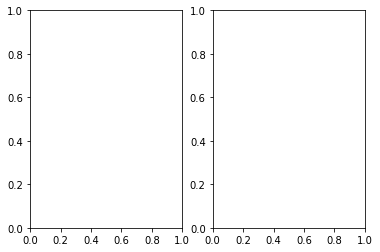

interactive(children=(FloatSlider(value=0.0, description='v', max=3.0, min=-3.0, step=0.2), Output()), _dom_cl…

<function __main__.<lambda>(v)>

In [15]:
plt.subplots(1,2)
interact(lambda v: soft_thres_visu(v), v=widgets.FloatSlider(min=-3.0,max=3.0, step=0.2, value=0))

##### Efficient implementation of $z$-update for isotropic TV regularizer

For the isotropic case, the $l_2$-norm of the finite differences approximation of the horizontal and vertical image gradients is used as the regularizer instead of the $l_1$-norm, i.e.,

$\begin{align} 
   \lambda \left\| \mathbf{z} \right\|_{2,1}  = \lambda \sum\limits^N_{i=1} \left\|  \begin{bmatrix} 
      (\mathbf{D}_x \mathbf{x})_i \\ (\mathbf{D}_y \mathbf{x})_i
   \end{bmatrix}  \right\|_2 = \lambda \sum\limits^N_{i=1} \sqrt{(\mathbf{D}_x \mathbf{x})^2_i + (\mathbf{D}_y \mathbf{x})^2_i } \,.
\end{align}$

This expression is also called the *group lasso*.

Accordingly, the whole deconvolution problem for the isotropic TV regularizer is

$\begin{align} 
   &\argmin{\mathbf{x}}\, \underbrace{\frac{1}{2} \left\| \mathbf{Cx-b} \right\|^2_2}_{=:f(\mathbf{x})} + \underbrace{\lambda \sum\limits^N_{i=1} \left\|  \begin{bmatrix} 
      z_i \\ z_{i+N}
   \end{bmatrix}   \right\|_2 }_{=:g(\mathbf{z})} \\
   &\text{subject to } \mathbf{Dx-z=\mathbf{0}}\,.
\end{align}$

Again, the vector $\mathbf{z} \in \mathbb{R}^{2\times N}$ so that its first, respectively, second half can hold the image gradients in $x$-direction, respectively, in $y$-direction, i.e., $\mathbf{z} = \left[ \mathbf{D}_x \mathbf{x}\,\, \mathbf{D}_y \mathbf{x}   \right]\transp $.

As only the regularization term $g(\mathbf{z})$ has changed, we only have to derive a corresponding $\mathbf{z}$-update rule, i.e., we have to find a solution for the proximal operator

$\begin{align} 
   \mathbf{z} \leftarrow \mathbf{prox}_{\left\| \cdot \right\|_{2,1},\rho } (\mathbf{v}) = \argmin{\mathbf{z}}\,\, \lambda \sum\limits^N_{i=1} \left\| \begin{bmatrix} 
    z_i \\ z_{i+N}
 \end{bmatrix}   \right\|_2  + \frac{\rho}{2} \left\| \mathbf{v-z} \right\| ^2_2, \quad \mathbf{v=Dx} \,.
\end{align}$

Therefore, we again extract the term we have to minimize:

$\begin{align}\label{eq:hqs:iso:1}
   h(\mathbf{z}) := \lambda \left\| \mathbf{z} \right\|_2 + \frac{\rho}{2} \left\| \mathbf{v-z} \right\| ^2_2 \,.
\end{align}$

We follow the approach of calculating the gradient of $h(\mathbf{z})$, equating it to $\mathbf{0}$ and solving for $\mathbf{z}$.

The gradient of the second term with respect to $\mathbf{z}$ can be calculated straight forward:

$\begin{align} 
   \nabla_\mathbf{z} \frac{\rho}{2} \left\| \mathbf{v-z} \right\| ^2_2 = \rho (-\mathbf{v} + \mathbf{z}) \,.
\end{align}$

The gradient of the Euclidean norm $\left\| \mathbf{x} \right\| _2$ is

$\begin{align} 
   \nabla_\mathbf{x} \left\| \mathbf{x} \right\|_2 = \frac{\mathbf{x}}{\left\| \mathbf{x} \right\|_2 }, \quad \text{for } \mathbf{x} \neq \mathbf{0} \,.
\end{align}$

Hence, the gradient of the first term of \eqref{eq:hqs:iso:1} is 

$\begin{align} 
   \nabla_\mathbf{z} \lambda \left\| \mathbf{z} \right\| _2 = \lambda \frac{\mathbf{z}}{\left\| \mathbf{z} \right\|_2 } \quad \text{for } \mathbf{z} \neq \mathbf{0} \,.
\end{align}$

So for $\mathbf{z} \neq \mathbf{0}$, we will find a $\hat{\mathbf{z}}$ with $  \nabla_\mathbf{z} \lbrace h(\mathbf{z}) \rbrace (\hat{\mathbf{z}}) = \mathbf{0}$:

$\begin{align} 
  \lambda \frac{\mathbf{z}}{\left\| \mathbf{z} \right\|_2 } +  \rho (-\mathbf{v} + \mathbf{z}) &\overset{!}{=} \mathbf{0} \\
  \mathbf{z}\left( \frac{\lambda}{\left\| \mathbf{z} \right\|_2 } + \rho \right) &= \rho \mathbf{v} \,. \label{eq:hqs:iso:2}
\end{align}$

We now apply the $l_2$-norm to both sides of the equation:

$\begin{align}  \label{eq:hqs:iso:3}
   \left| \frac{\lambda}{\left\| \mathbf{z} \right\|_2 }  + \rho\right| \cdot \left\| \mathbf{z} \right\|_2 = \left| \rho \right|  \left\| \mathbf{v} \right\|_2 \,.
\end{align}$

The last step introduced two absolute values for each of which the two possible cases, .i.e, $>0$, $<0$ have to be considered. Regarding the term $\left| \rho \right| $ on the right side of the equation, only the positive case has to be considered since $\rho > 0$ by definition.

The first absolute term $\left| \frac{\lambda}{\left\| \mathbf{z} \right\|_2 }  + \rho\right|$ is positive if

$\begin{align} 
  \frac{\lambda}{\left\| \mathbf{z} \right\|_2 }  + \rho &> 0 \\  - \frac{\lambda}{\rho} &< \left\| \mathbf{z} \right\| _2 \,,
\end{align}$

what always holds since due to $\lambda > 0$ and $\rho > 0$ it follows $-\frac{\lambda}{\rho} < 0$ and since  $\left\| \mathbf{z} \right\| _2 > 0$ as $\left\| \cdot \right\| \geq 0$ for any norm and $\mathbf{z} \neq \mathbf{0}$ by definition of the considered case. Hence, the negative case is impossible.

We continue to solve \eqref{eq:hqs:iso:3} for $\left\| \mathbf{z} \right\| _2$:

$\begin{align} 
  \left( \frac{\lambda}{\left\| \mathbf{z} \right\|_2 }  + \rho\right) \cdot \left\| \mathbf{z} \right\|_2 &= \rho  \left\| \mathbf{v} \right\|_2  \\
  \lambda + \rho \left\| \mathbf{z} \right\| _2 &= \rho \left\| \mathbf{v} \right\| _2 \\
  \left\| \mathbf{z} \right\| _2 &= \frac{\rho \left\| \mathbf{v} \right\|_2 - \lambda  }{\rho} \,,
\end{align}$

and now insert this expression for $\left\| \mathbf{z} \right\| _2$ into \eqref{eq:hqs:iso:2} and solve for $\mathbf{z}$:

$\begin{align} 
   \mathbf{z} \left( \lambda \cdot \frac{\rho }{\rho \left\| \mathbf{v} \right\|_2 - \lambda } + \rho  \right) &= \rho \mathbf{v} \\
   \mathbf{z} \frac{\lambda + \rho  \left\| \mathbf{v} \right\|_2 - \lambda  }{\rho  \left\| \mathbf{v} \right\|_2 - \lambda  } &= \mathbf{v}  \\
   \mathbf{z} &= \mathbf{v} \cdot \frac{\rho  \left\| \mathbf{v} \right\|_2 - \lambda  }{\rho  \left\| \mathbf{v} \right\|_2 } \\
   \mathbf{z} &= \mathbf{v} \cdot \left( 1 - \frac{\lambda }{\rho \left\| \mathbf{v} \right\|_2 } \right) \,.
\end{align}$

In order to make sure that $\mathbf{z} \overset{!}{\neq} \mathbf{0}$, we have to check for which conditions $\left( 1 - \frac{\lambda }{\rho \left\| \mathbf{v} \right\|_2 } \right) > 0$ holds (we do not have to check for $<0$ as this is impossible as we showed when inspecting the absolute terms before):

$\begin{align} 
  \left( 1 - \frac{\lambda }{\rho \left\| \mathbf{v} \right\|_2 } \right) &> 0 \\
  \left\| \mathbf{v} \right\|_2 &> \frac{\lambda }{\rho } \,.
\end{align}$

For $\mathbf{z} = \mathbf{0}$, there is no well-defined gradient for $\left\| \mathbf{z} \right\|_2$, so we make use of the concept of subdifferentials again and derive the subdifferential of $h(\mathbf{z})$ with respect to position $\mathbf{z} = \mathbf{0}$:

$\begin{align} 
  h(\mathbf{z}) &= \lambda \left\| \mathbf{z} \right\|_2 + \frac{\rho}{2} \left\| \mathbf{v-z} \right\| ^2_2 \\
  \frac{h(\mathbf{z})}{\rho} &= \frac{\lambda}{\rho } \left\| \mathbf{z} \right\|_2 + \frac{1}{2} \left\| \mathbf{v-z} \right\|^2_2  \\
  \partial_\mathbf{0} \frac{h(\mathbf{z})}{\rho} &= \partial_\mathbf{0} \frac{\lambda}{\rho } \left\| \mathbf{z} \right\|_2 \oplus  \partial_\mathbf{0}\frac{1}{2} \left\| \mathbf{v-z} \right\|^2_2 \,.
\end{align}$

As before, we can replace the second subdifferential on the right side of the equation with the true gradient:

$\begin{align} 
  \partial_\mathbf{0} \frac{h(\mathbf{z})}{\rho} &= \partial_\mathbf{0} \frac{\lambda}{\rho } \left\| \mathbf{z} \right\|_2 \oplus  \lbrace - \mathbf{v} \rbrace \,.
\end{align}$

For the first term, i.e., $\partial_\mathbf{0}\frac{\lambda}{\rho} \left\| \mathbf{z} \right\|_2$, we employ the definition of subdifferentials:

$\begin{align} 
  \partial_\mathbf{0}\frac{\lambda}{\rho} \left\| \mathbf{z} \right\|_2 &= \left\{ \mathbf{g} \in \mathbb{R}^{2N} : \frac{\lambda}{\rho} \left\| \mathbf{z} \right\|_2 \geq \frac{\lambda}{\rho} \left\| \mathbf{0} \right\|_2 + \left\langle \mathbf{g} , \mathbf{z} - \mathbf{0}\right\rangle  \right\} \\
  \partial_\mathbf{0}\frac{\lambda}{\rho} \left\| \mathbf{z} \right\|_2 &= \left\{ \mathbf{g} \in \mathbb{R}^{2N} : \frac{\lambda}{\rho} \left\| \mathbf{z} \right\|_2 \geq \left\langle \mathbf{g} , \mathbf{z}\right\rangle  \right\} \,.
\end{align}$

By means of the Cauchy-Schwarz inequality, i.e., $\left\langle \mathbf{g}, \mathbf{z} \right\rangle \leq \left\| \mathbf{g} \right\| \cdot \left\| \mathbf{z} \right\| $, we can further simplify the derivation:

$\begin{align} 
  \partial_\mathbf{0}\frac{\lambda}{\rho} \left\| \mathbf{z} \right\|_2 &= \left\{ \mathbf{g} \in \mathbb{R}^{2N} : \frac{\lambda}{\rho} \left\| \mathbf{z} \right\|_2 \geq \left\langle \mathbf{g} , \mathbf{z}\right\rangle  \right\} \\
  &= \left\{ \mathbf{g} \in \mathbb{R}^{2N} : \frac{\lambda}{\rho} \left\| \mathbf{z} \right\|_2 \geq \left\| \mathbf{g} \right\|_2 \cdot \left\| \mathbf{z} \right\|_2     \right\} \\
  &= \left\{ \mathbf{g} \in \mathbb{R}^{2N} : \frac{\lambda}{\rho}  \geq \left\| \mathbf{g} \right\|_2      \right\} \,.
\end{align}$

The resulting combined expression for the subdifferential of $\frac{h(\mathbf{z})}{\rho} $ is:

$\begin{align} 
   \partial_\mathbf{0}\frac{h(\mathbf{z})}{\rho} = \left\{ \mathbf{g} \in \mathbb{R}^{2N} : \frac{\lambda}{\rho}  \geq \left\| \mathbf{g} \right\|_2      \right\} \oplus \lbrace -\mathbf{v} \rbrace \,.
\end{align}$ 

For $\mathbf{z} = \mathbf{0}$ we want to return $\mathbf{0}$ if possible since that would correspond to the sought minimum. A subgradient $\mathbf{0}$ is contained in $\partial_\mathbf{0}\frac{h(\mathbf{z})}{\rho}$ if the first subdifferential $\left\{ \mathbf{g} \in \mathbb{R}^{2N} : \frac{\lambda}{\rho}  \geq \left\| \mathbf{g} \right\|_2      \right\}$ contains a vector $\mathbf{g}$ with $\mathbf{g} = \mathbf{v}$ because then the Minkowski sum $\left\{ \mathbf{g} \in \mathbb{R}^{2N} : \frac{\lambda}{\rho}  \geq \left\| \mathbf{g} \right\|_2      \right\} \oplus \lbrace -\mathbf{v} \rbrace$ would contain $\mathbf{0}$. This is only possible for any vectors $\mathbf{v}$ with $\left\| \mathbf{v} \right\|_2 \leq \frac{\lambda}{\rho}  $.

With these results, the final $\mathbf{z}$-update rule is given by:

The concept of subdifferentials yields the sought $\mathbf{z}$-update rule:

$\begin{align} 
  \begin{bmatrix} 
     z_i \\ z_{i+N}
  \end{bmatrix} \leftarrow \mathcal{S}_{\lambda / \rho} \left(\mathbf{v}':= \begin{bmatrix} 
     v_i \\ v_{i+N}
  \end{bmatrix} \right) =  \begin{cases} 
    \mathbf{v}' \cdot \left( 1 - \frac{\lambda }{\rho \left\| \mathbf{v}' \right\|_2 } \right) &\text{if } \left\| \mathbf{v}' \right\| _2 > \frac{\lambda}{\rho} \\
    \mathbf{0} &\text{if } \left\| \mathbf{v}' \right\| _2 \leq \frac{\lambda}{\rho}
  \end{cases}
   \,.
\end{align}$

This expression (i.e., $\mathcal{S}_{\lambda / \rho}$) is also known as the vector soft-thresholding operator.

##### Efficient update of $\mathbf{z}$ in general case

In the general case, i.e., with $\mathbf{D} = \mathbf{I}$, we want to solve

$\begin{align} 
   \mathbf{z} \leftarrow &\argmin{\mathbf{z}}\, g(\mathbf{z}) + \frac{\rho}{2} \left\| \mathbf{x} - \mathbf{z} \right\| ^2_2 \,, \\
   &\argmin{\mathbf{z}}\, \lambda \Psi(\mathbf{z}) + \frac{\rho}{2} \left\| \mathbf{x-z} \right\|^2_2 \,, \\
   &\argmin{\mathbf{z}}\,  \Psi(\mathbf{z}) + \frac{\rho}{2\lambda} \left\| \mathbf{x-z} \right\| ^2_2 \,.
\end{align}$

For $\frac{\lambda}{\rho} = \sigma^2$, the last equation represents a denoising problem for zero-mean Gaussian noise with variance $\sigma^2$ as we have seen earlier:

$\begin{align} 
  \argmin{\mathbf{s}}\, \Gamma (\mathbf{s}) + \frac{1}{2\sigma^2}\left\| \mathbf{g} - \mathbf{s} \right\|^2_2   \,.
\end{align}$

This means that we can use any Gaussian denoiser $\mathcal{D}: \mathbb{R} ^N \rightarrow  \mathbb{R} ^N$ as our proximal operator for the $z$-update, e.g., the denoising CNN from the last chapter.

$\rightarrow$ Any Gaussian denoiser suitable for a noise variance of $\sigma^2$ can be used as a general image prior:

$\begin{align} 
   \mathbf{z} \leftarrow \mathrm{prox}_{\mathcal{D}, \rho} (\mathbf{x}) =\mathcal{D}\left( \mathbf{x}, \sigma^2 = \frac{\lambda}{\rho}  \right)  \,.
\end{align}$

### HQS for general linear inverse problems

HQS can also be applied to linear inverse problems, i.e., $\mathbf{b} = \mathbf{Ax} + \mathbf{n}$.

Depending on the prior, we can use the $\mathbf{z}$-updates already derived for the deconvolution problem (i.e., total variation or a general Gaussian denoiser).

However, we have to look again at the $\mathbf{x}$-update, as the matrix-vector multiplication $\mathbf{Ax}$ does not (necessarily) encode a convolution anymore.

##### Derivation of $\mathbf{x}$-update for HQS for general linear inverse problems

For the $\mathbf{x}$-update, we use the following solution:

$\begin{align} 
   \mathbf{x} \leftarrow \mathrm{prox}_{\left\| \cdot \right\| _2, \rho} (\mathbf{v}) &= \argmin{\mathbf{x}}\, \frac{1}{2} \left\| \mathbf{Ax-b} \right\| ^2_2 + \frac{\rho}{2}\left\| \mathbf{Dx-z} \right\| ^2_2  \\
   &= \left( \underbrace{\mathbf{A}\transp \mathbf{A} + \rho  \mathbf{D}\transp D}_{\tilde{\mathbf{A}}} \right)^{-1}  \left( \underbrace{\mathbf{A}\transp \mathbf{b} + \rho \mathbf{D}\transp \mathbf{z}}_{\tilde{\mathbf{b}}} \right) \,,
\end{align}$

whose derivation is equivalent to the deconvolution problem.

Unfortunately, for the case of a general matrix $\mathbf{A}$, there is no elegant closed-form solution as for the case of deconvolution. 

$\rightarrow$ Use an iterative solver to solve $\tilde{\mathbf{A}} \mathbf{x} = \tilde{\mathbf{b}}$ for $\mathbf{x}$. Since $\tilde{\mathbf{A}}$ is symmetric and positive semi-definite, the so-called *conjugate gradient* method is a good choice.

### Problems of HQS

The HQS method works well for inverse problems where the number of available measurements $M$ is in the range of the number of unknowns $N$. For the case of deconvolution, it is $M=N$ and hence HQS represents a suitable choice.

However, for severely under-determined problems, the penalty $\frac{\rho}{2}\left\| \mathbf{Dx-z} \right\|^2_2 $ linking data fidelity and the prior terms can be too weak so that the algorithm does not converge well.

We will now get to know a method that mitigates that problem.

## Alternating direction method of multipliers (ADMM)

Similar to the HQS approach, the so-called *alternating direction method of multipliers (ADMM)* splits the objective function

$
\begin{align} 
  \argmin{\mathbf{x}}\quad &\underbrace{\frac{1}{2}\left\| \mathbf{Ax-b} \right\|^2_2 }_{=:f(\mathbf{x})} + \underbrace{\lambda \Psi (\mathbf{z})}_{=:g(\mathbf{z})} \\
  \text{subject to}\quad &\mathbf{Dx-z} = \mathbf{0} \,.
\end{align}
$

into multiple terms and optimizes it in an alternating fashion.

But instead of transforming the constraint $\mathbf{Dx-z} = \mathbf{0}$ into a penalty term, it employs the so-called *augmented Lagrangian* of the objective function:

$\begin{align} 
   L^\mathrm{(ADMM)}_\rho (\mathbf{x,z,y}) = f(\mathbf{x}) + g(\mathbf{z}) + \mathbf{y}\transp \left( \mathbf{Dx-z} \right) + \frac{\rho}{2} \left\| \mathbf{Dx-z} \right\| ^2_2 \,,
\end{align}$

with the Lagrange multiplier $\mathbf{y}$.

The so-called *scaled form* of the augmented Lagrangian is given by

$\begin{align} 
  L^\mathrm{(ADMM)}_\rho (\mathbf{x,z,u}) = f(\mathbf{x}) + g(\mathbf{z}) + \frac{\rho}{2} \left\| \mathbf{Dx-z+u} \right\|^2_2 - \frac{\rho}{2} \left\| \mathbf{u} \right\| ^2_2  \,,
\end{align}$

with the scaled Lagrangian multiplier $\mathbf{u} = \frac{1}{\rho} \mathbf{y}$.

```{note}
   The augmented Lagrangian and its scaled form are identical, i.e., just mathematical reformulations that come in handy for further steps.
```

The update rules for the variables $\mathbf{x,z,u}$ are given by

$\begin{align} 
   \mathbf{x} &\leftarrow \mathrm{prox}_{\left\| \cdot \right\|_2, \rho } (\mathbf{v}) =\argmin{\mathbf{x}}\, L^{\mathrm{(ADMM)}}_\rho (\mathbf{x,z,u}) = \argmin{\mathbf{x}}\, \frac{1}{2} \left\| \mathbf{Ax-b} \right\|^2_2 + \frac{\rho}{2} \left\| \mathbf{Dx-z+u} \right\|^2_2 \,, \\
   \mathbf{z} &\leftarrow  \mathrm{prox}_{\Psi, \rho}(\mathbf{v}) = \argmin{\mathbf{z}}\, L^{\mathrm{(ADMM)}}_\rho (\mathbf{x,z,u}) = \argmin{\mathbf{z}}\, \lambda \Psi (\mathbf{z}) + \frac{\rho}{2} \left\| \mathbf{Dx-z+u} \right\|^2_2 \,, \\
   \mathbf{u} &\leftarrow \mathbf{u} + \mathbf{Dx-z}
\end{align}$

For the $\mathbf{x}$- and $\mathbf{z}$-updates we can again use proximal operators. The $\mathbf{u}$-update is a straightforward sum of vectors (for its derivation see the article [Distributed Optimization and Statistical Learning via the Alternating Direction Method of Multipliers](https://web.stanford.edu/~boyd/papers/pdf/admm_distr_stats.pdf) by Stephen Boyd et al.).

##### The $\mathbf{x}$-update:

The $\mathbf{x}$-update within ADMM is quite similar to that of HQS, we just have to adequately account for $\mathbf{u}$, i.e.,

$\begin{align} 
  \mathrm{prox}_{\left\| \cdot \right\|_2, \rho } (\mathbf{\mathbf{z-u}}) = \left( \underbrace{\mathbf{A}\transp \mathbf{A} + \rho  \mathbf{D}\transp D}_{\tilde{\mathbf{A}}} \right)^{-1}  \left( \underbrace{\mathbf{A}\transp \mathbf{b} + \rho \mathbf{D}\transp (\mathbf{z-u})}_{\tilde{\mathbf{b}}} \right) \,.
\end{align}$

##### The $\mathbf{z}$-update:

For the $\mathbf{z}$-update, we can rely on the same proximal operators as HQS.

In the case of the TV regularizer, the proximal operator is the element-wise soft thresholding operator:

$\begin{align} 
  \mathrm{prox}_{\left\| \cdot \right\|_1, \rho } (\mathbf{v}) = \argmin{\mathbf{z}}\, \lambda \left\| \mathbf{z} \right\|_1 + \frac{\rho}{2}\left\| \mathbf{v-z} \right\|^2_2 = \mathcal{S}_{\lambda / \rho} (\mathbf{v})\,.  
\end{align}$

Since for HQS it is $\mathbf{v} = \mathbf{Dx}$, we again have to account for $\mathbf{u}$ as $\mathbf{v} = \mathbf{Dx} + \mathbf{u}$.

In the general case, i.e., for $\mathbf{D=I}$, we can use any Gaussian denoiser $\mathcal{D}: \mathbb{R} ^N \rightarrow \mathbb{R}^N$ as a regularizer leading to the following $\mathbf{z}$-update:

$\begin{align} 
   \mathrm{prox}_{\mathcal{D}, \rho} (\mathbf{v}) = \mathcal{D} \left( \mathbf{v}, \sigma^2=\frac{\lambda }{\rho} \right) \,,
\end{align}$

with $\mathbf{v = x + u}$.

## Deep SNR-estimation for Wiener filtering

As elaborated before, one main drawback of the Wiener filter is the necessity for the user to correctly estimate the signal-to-noise ratio 

$\begin{align} 
   SNR\,(\mathbf{f}) = \frac{S_{ss}(\mathbf{f})}{S_{nn}(\mathbf{f})} \,, 
\end{align}$

with $S_{ss}(\mathbf{f}), S_{nn}(\mathbf{f})$ denoting the power spectral density of the signal component, respectively, of the noise component.

In the unusual case when one has access to $s$ and $n$, it is possible to calculate (not unbiased) estimates of $S_{ss}(\mathbf{f}), S_{nn}(\mathbf{f})$ via

$\begin{align} 
   \hat{S}_{ss}(\mathbf{f}) &= \vert \F \left\{ s(\mathbf{x}) \right\}   \vert^2 \, , \\
   \hat{S}_{nn}(\mathbf{f}) &= \vert \F \left\{ n(\mathbf{x}) \right\}   \vert^2 \,.
\end{align}$

Fortunately we could show that a neural network $\phi$ can be trained to precisely estimate the signal-to-noise ratio based on the observed image $g$ only.

To make the task easier for the neural network, we trained it to consume estimates of the power spectral density of $g$ to estimate the signal-to-noise ratio. By this means, both input and output have spatial frequencies as variables.

Directly training $\phi$ with pairs of $\left( \hat{S}_{gg}, \widehat{SNR} \right)$ would lead to slow or even no convergence of the training due to the high dynamic range of the squared magnitude spectra of the Fourier transforms.

Hence, we train $\phi$ with pairs $\left(  \log \hat{S}_{gg}, \log \widehat{SNR} \right)$,i.e., so that $\phi\left( \log \hat{S}_{gg}(\mathbf{f})\right)= \log \widehat{SNR}\,(\mathbf{f})$.

The following figure visualizes the training procedure:

<img src="figures/6/dw_training.svg" style="max-height:40vh">

To apply the method for image reconstruction the following steps are performed:
* Calculate $\hat{S}_{gg}(\mathbf{f}) = \left| \F \left\{ g(\mathbf{x}) \right\}  \right|^2 $ for the observed image $g$,
* use $\phi$ to estimate the signal-to-noise ratio via $\widehat{SNR}\,(\mathbf{f}) \leftarrow \phi(\hat{S}_{gg}(\mathbf{f})) $,
* estimate the undistorted image $\hat{s}$ by applying the Wiener filter to $g$ and by using the estimated $\widehat{SNR}$.

##### Example Wiener filter reconstruction results with deep SNR-estimation

In [16]:
interact(lambda i: showFig('figures/6/dw_ex_',i,'.png',800,50), i=widgets.IntSlider(min=(min_i:=1),max=(max_i:=8), step=1, value=(6 if book else min_i)))

interactive(children=(IntSlider(value=6, description='i', max=8, min=1), Output()), _dom_classes=('widget-inte…

<function __main__.<lambda>(i)>

##### Quantitative results

To quantify the deconvolution performance of the proposed method, the [dataset published by Libin Sun et al.](http://ieeexplore.ieee.org/document/6528301/) has been employed.

The reconstruction results are numerically compared against the ground truths by means of the so-called *peak signal-to-noise ratio PSNR* (logarithmic scale, no maximum value) and the so-called *structural similarity index SSIM* (mimics the human perception of image similarity, maximum value of 1.0 for full equality).

<table>
<thead>
  
  <tr>
      <th style="text-align:left">Method</th>
      <th>PSNR</th>
      <th>SSIM</th>
  </tr>
</thead>
<tbody>
  
  <tr>
    <td style="text-align:left">Fourier Deconvolution Network (2017)</td>
    <td>32.67</td>
    <td>0.8887</td>
  </tr>
  <tr>
    <td style="text-align:left">Cascade of Shrinkage Fields (2014)</td>
    <td>32.21</td>
    <td>0.8622</td>
  </tr>
  <tr>
    <td style="text-align:left">Expected Patch Log Likelihood (2011)</td>
    <td>32.48</td>
    <td>0.8815</td>
  </tr>
  <tr>
    <td style="text-align:left">Wiener meets Deep Learning (2020)</td>
    <td>34.05</td>
    <td>0.9225</td>
  </tr>
  <tr>
      <td style="text-align:left"><b>Wiener filter with deep SNR-estimation</b></td>
      <td><b>40.83 $\pm$ 1.8</b></td>
      <td><b>0.97 $\pm$ 0.01</b></td>
  </tr>
  <tr >
    <td colspan="100%"></td>
  </tr>
  <tr>
    <td style="text-align:left">Wiener filter with ground truth SNR</td>
    <td>42.31 $\pm$ 1.7</td>
    <td>0.98 $\pm$ 0.01</td>
  </tr>
  <tr>
    <td style="text-align:left">Wiener filter with heuristic $\mathbf{f}^2$</td>
    <td>32.23 $\pm$ 2.3</td>
    <td>0.81 $\pm$ 0.1</td>
  </tr>
</tbody>
</table>

## Unrolled optimization

For traditional HQS and ADMM implementations, the values of the hyperparameters $\lambda$ and $\rho$ are chosen once and remain fix while performing the optimization.

Although this works well in many cases, it can be beneficial to set the number $i$ of iterations to a fixed value and replicate the parameter update routines $i$ times, each with individual hyperparameters $\lambda_i, \rho_i$.

The resulting structure can be interpreted and dealt with like a neural network (especially if some deep denoising prior is included). Then, the hyperparameters $\lambda_i, \rho_i$ and the parameters of a potentially included neural network can be learned (i.e., optimized) in an end-to-end fashion in a joint training procedure.

Advantages of unrolled optimization:

* Whole method becomes end-to-end differentiable.
* Hyperparameters $\lambda_i, \rho_i$ can be learned and optimized allowing to realize a hyperparameter-schedule (e.g., increasing the $\rho_i$ over time).
* The denoising neural network can adapt to the actual matrix $\mathbf{A}$ or the convolution kernel (even with respect to every individual iteration).
* Skip connections from earlier iterations to later iterations can be realized.